## load data set

# test package

In [1]:
# import pydot

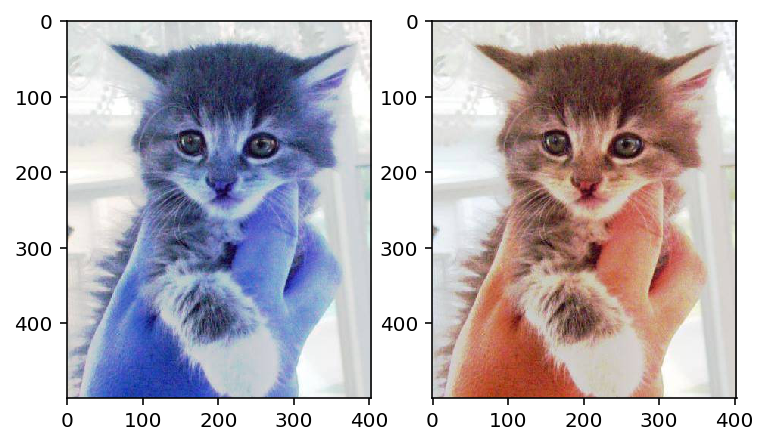

100%|██████████| 500/500 [00:05<00:00, 95.43it/s]


array([203, 164,  87], dtype=uint8)

array([222, 123, 162], dtype=uint8)

0

In [59]:
import numpy as np
from tqdm import tqdm
import cv2
from IPython.display import display
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

debugMode = True
testWorkflow = True
numberData = 25000
InceptionResNetV2Size = 299

# if testWorkflow:
#     numberData = 1000

if debugMode:
    test = cv2.imread('train/cat.100.jpg')
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(test)
    ax = fig.add_subplot(122)
    test2 = test[:,:,::-1]
    ax.imshow(test2)
    plt.show()
    
x = np.zeros((numberData, InceptionResNetV2Size, InceptionResNetV2Size, 3), dtype=np.uint8)
y = np.zeros((numberData, 1), dtype=np.uint8)

for index in tqdm(range(0, numberData, 2)):
    x[index] = cv2.resize(cv2.imread('train/cat.%d.jpg' %(index/2))[:,:,::-1], (InceptionResNetV2Size, InceptionResNetV2Size))
    x[index + 1] = cv2.resize(cv2.imread('train/dog.%d.jpg' %(index/2))[:,:,::-1], (InceptionResNetV2Size, InceptionResNetV2Size))
    y[index + 1] = 1

if debugMode:
    display(x[0][0][0])
    display(x[1][100][100])
    display(y[0][0])
    
                              
                              
# import numpy as np
# from tqdm import tqdm
# import cv2

# np.random.seed(2017)

# n = 25000
# X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
# y = np.zeros((n, 1), dtype=np.uint8)

# for i in tqdm(range(n/2)):
#     X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (224, 224))
#     X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (224, 224))

# y[n/2:] = 1

In [3]:
## split as train and val

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=6)

if debugMode:
    print (x_train[:, 0, 0, 0].size)
    print (y_val.size)

800
200


## build the transfer learning mode

In [61]:
# from keras.applications.inception_resnet_v2.InceptionResNetV20 import InceptionResNetV20
import keras
# from keras.applications.inception_resnet_v2.InceptionResNetV2 import InceptionResNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Model


input_tensor = Input(shape=(InceptionResNetV2Size, InceptionResNetV2Size, 3))
# modelInceptionResNetV20 = InceptionResNetV20(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=None, pooling=None, classes=1000)
modelInceptionResNetV2 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

#lock all pre-trained layers
for layers in modelInceptionResNetV2.layers:
    layers.trainable = False
    
x = modelInceptionResNetV2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
prediction = Dense(1,activation='sigmoid')(x)
model = Model(inputs=modelInceptionResNetV2.input, outputs=prediction)

print('done')

# base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

# for layers in base_model.layers:
#     layers.trainable = False

# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.25)(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(base_model.input, x)


# from keras.applications.vgg16 import VGG16
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input
# import numpy as np

# model = VGG16(weights='imagenet', include_top=False)

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# features = model.predict(x)

# from keras.layers import Dense, GlobalAveragePooling2D
# from keras import backend as K

# # create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(200, activation='softmax')(x)

done


In [31]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val), verbose=debugMode)
# model.fit(x_train, y_train, batch_size=16, epochs=5, validation_data=(x_valid, y_valid))
print ('done')

Train on 1600 samples, validate on 400 samples
Epoch 1/2
1600/1600 [==============================] - 799s 499ms/step - loss: 0.4219 - acc: 0.8263 - val_loss: 7.5755 - val_acc: 0.5300
Epoch 2/2
1600/1600 [==============================] - 757s 473ms/step - loss: 0.2141 - acc: 0.9444 - val_loss: 7.5755 - val_acc: 0.5300
done


In [6]:
# import graphviz
# import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))
# from pydot import pydot


# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [57]:
layers = zip([x.name for x in model.layers], range(len(model.layers)))
if debugMode:
    pass
#     display(list(layers).head())


# CAM

(8, 8, 1536)
[0.56324893]


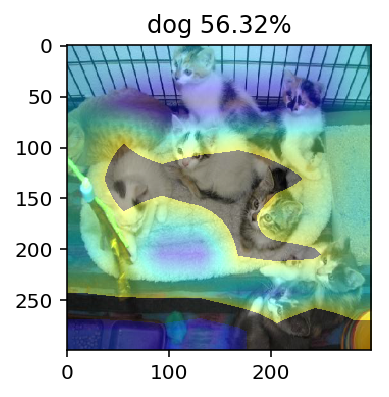

In [64]:
# testImg = x_val[np.random.randint(0, 19)]
# testImg = np.expand_dims(testImg, axis=0)

# outs_modelInceptionResNetV2 = modelInceptionResNetV2.predict(testImg)
# out_modelInceptionResNetV2 = outs_modelInceptionResNetV2[0]


weights = model.layers[-1].get_weights()
# display(weights)
# display(len(weights[0])
# display(len(weights))
weights = weights[0]        
        
    
#     weights = model.layers[177].get_weights()[0]
# model2 = Model(model.input, [model.layers[172].output, model.output])

figCAM = plt.figure()
# for i in range(8):
ax = figCAM.add_subplot(1, 2, 1)

sourceImg = cv2.imread('test/%d.jpg' % np.random.randint(0, 1000))[:, :, ::-1]
sourceImg = cv2.resize(sourceImg, (InceptionResNetV2Size, InceptionResNetV2Size))
testImg = sourceImg.copy()
testImg.astype(np.float32)
testImg = np.expand_dims(testImg, axis=0)

#     testImg.astype(np.float32)

out_modelInceptionResNetV2 = modelInceptionResNetV2.predict(testImg)
out_modelInceptionResNetV2 = out_modelInceptionResNetV2[0]

if debugMode:
    print(out_modelInceptionResNetV2.shape)

prediction = model.predict(testImg)
prediction = prediction[0]

if debugMode:
    print(prediction)

if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
else:
    plt.title('dog %.2f%%' % (prediction*100))

cam = (prediction - 0.5) * np.matmul(out_modelInceptionResNetV2, weights)
cam = (cam - cam.min()) / (cam.max() - cam.min())
cam -= 0.2
cam /= 0.8


cam = cv2.resize(cam, (InceptionResNetV2Size, InceptionResNetV2Size))
cam *= 255
cam = cam.astype(np.uint8)

heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
heatmap[np.where(cam <= 100)] = 0

out = cv2.addWeighted(sourceImg, 0.8, heatmap, beta=0.4, gamma=0)
# out = cv2.resize(out, dsize=(400, 400))
    
ax.imshow(out)
    
plt.show()
    
# plt.figure(figsize=(12, 14))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
#     img = cv2.resize(img, (224, 224))
#     x = img.copy()
#     x.astype(np.float32)
#     out, prediction = model2.predict(np.expand_dims(x, axis=0))

#     prediction = prediction[0]
#     out = out[0]

#     if prediction < 0.5:
#         plt.title('cat %.2f%%' % (100 - prediction*100))
#     else:
#         plt.title('dog %.2f%%' % (prediction*100))

#     cam = (prediction - 0.5) * np.matmul(out, weights)
#     cam -= cam.min()
#     cam /= cam.max()
#     cam -= 0.2
#     cam /= 0.8

#     cam = cv2.resize(cam, (224, 224))
#     heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
#     heatmap[np.where(cam <= 0.2)] = 0

#     out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

#     plt.axis('off')
#     plt.imshow(out[:,:,::-1])

# fine tuning

In [58]:
# #unlock all pre-trained layers
# for layers in modelInceptionResNetV2.layers:
#     layers.trainable = False

# model.compile(optimizer='Adam',
#           loss='binary_crossentropy',
#           metrics=['accuracy'])
# model.fit(x_train, y_train, batch_size=2, epochs=1, validation_data=(x_val, y_val))

In [ ]:
model.predict()